<a href="https://colab.research.google.com/github/mateusz-kacpura/exercises-python/blob/main/AWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rzeczywiste F2 dla poszczególnych zmiennych:
F2(X): 861
F2(Y): 1699
F2(Z): 2521

Statystyki estymacji AMS dla poszczególnych zmiennych:

Zmiennej X:
Średnia estymacji: 849.08
Mediana estymacji: 852.10
Odchylenie standardowe: 75.79
Rzeczywiste F2: 861

Zmiennej Y:
Średnia estymacji: 1678.81
Mediana estymacji: 1668.52
Odchylenie standardowe: 129.11
Rzeczywiste F2: 1699

Zmiennej Z:
Średnia estymacji: 2518.48
Mediana estymacji: 2495.80
Odchylenie standardowe: 171.34
Rzeczywiste F2: 2521


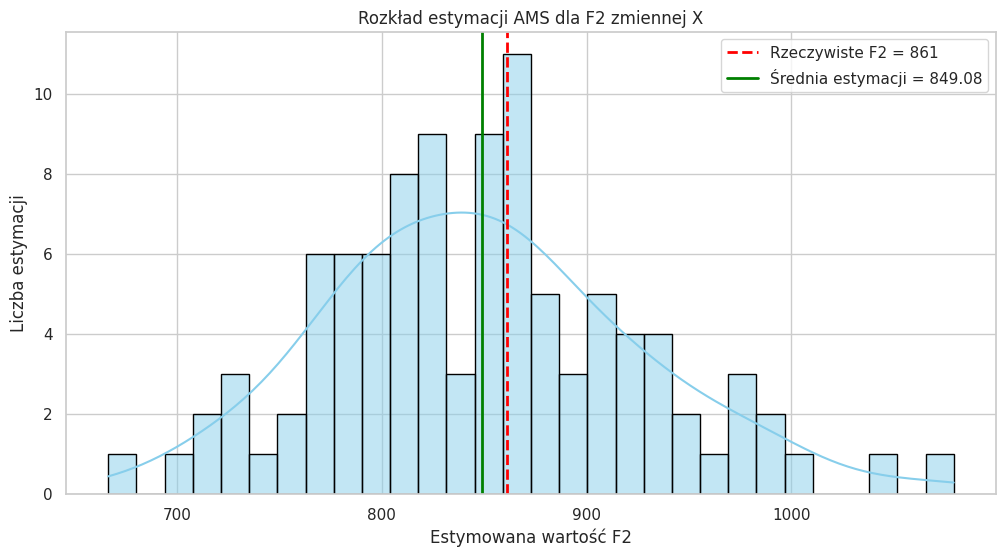

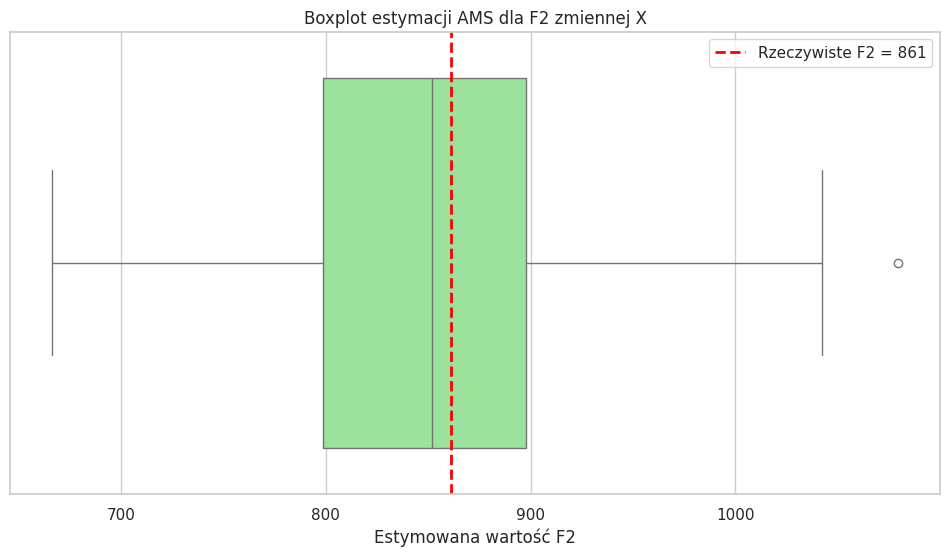

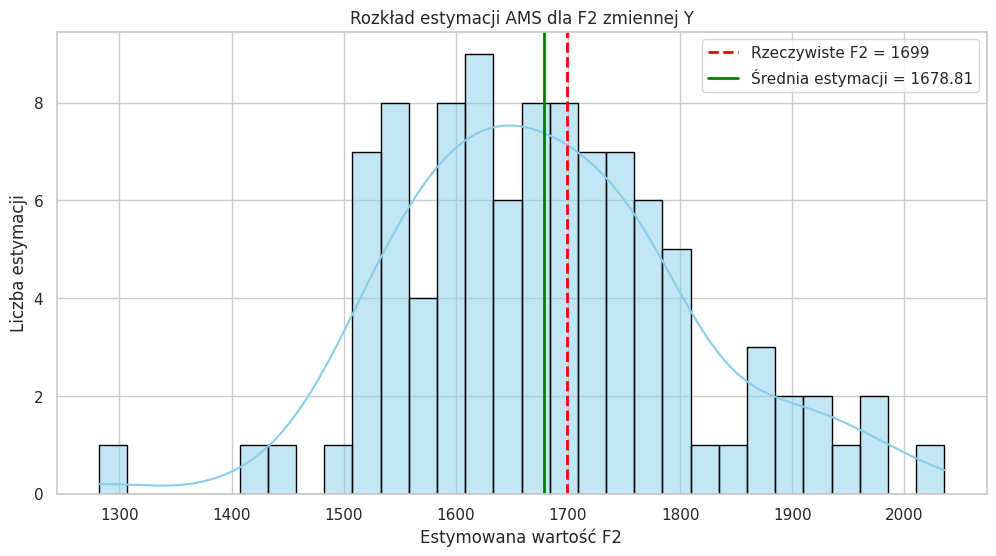

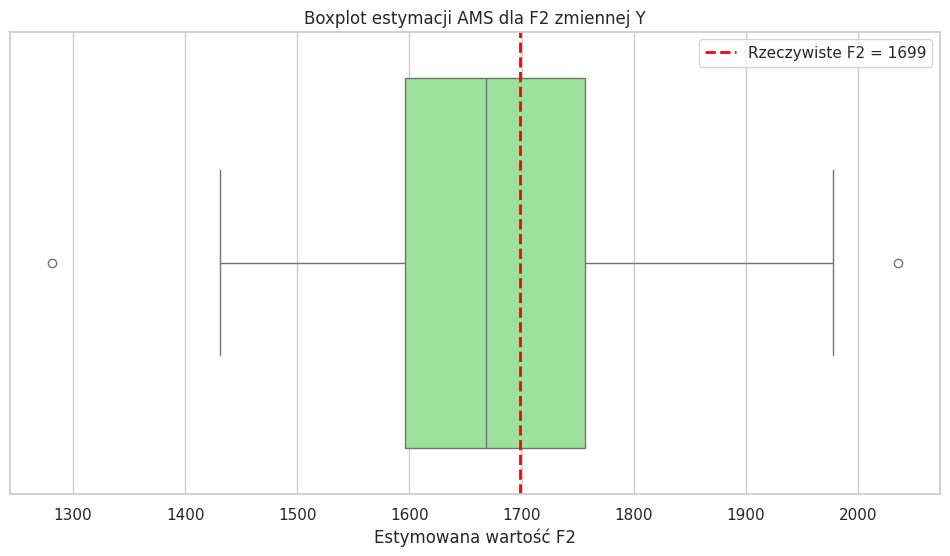

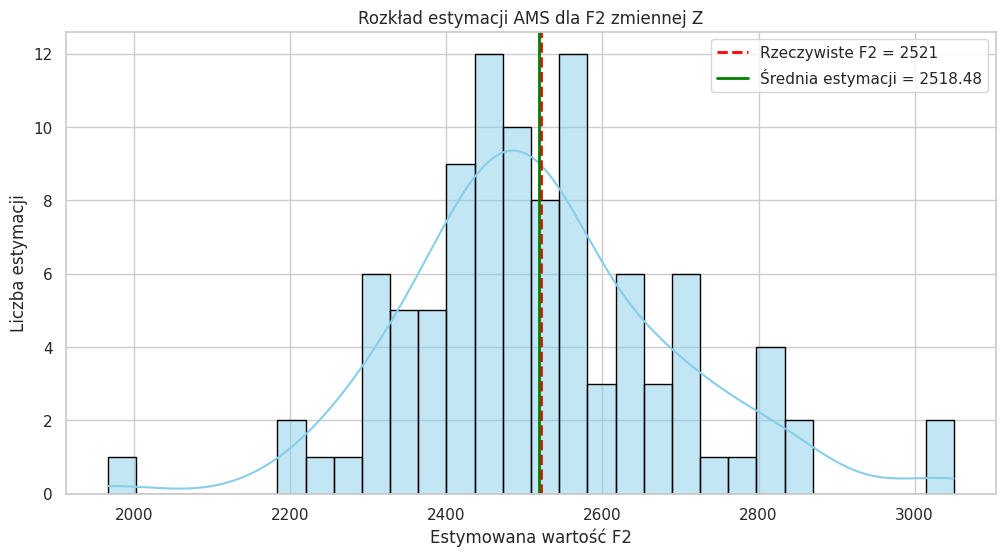

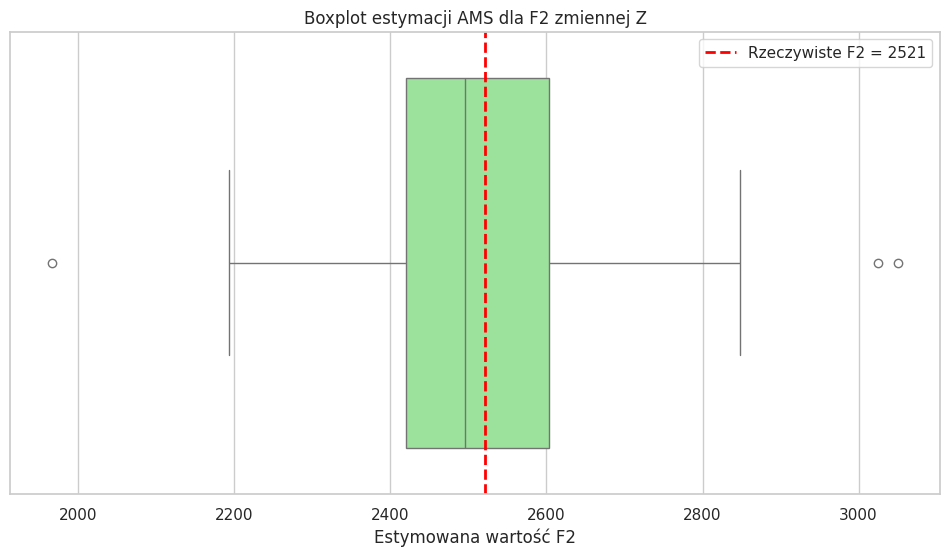

In [1]:
import numpy as np
import pandas as pd
import hashlib
import random
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia stylu wykresów
sns.set(style="whitegrid")

# Definicja 3-wymiarowego strumienia danych
stream = [
    (1, 'A', True), (2, 'B', False), (3, 'A'), (4, 'C', True),
    (5, 'B', False), (6, 'A', True), (4, 'B', False), (2, 'A', True),
    (5, 'C', False), (9, 'A', True), (1, 'B', False), (6, 'C', True),
    (3, 'A', False), (7, 'C', True), (1, 'B', False), (2, 'A', True),
    (2, 'B', False), (4, 'A', True), (2, 'C', False), (1, 'A', True),
    (3, 'B', False), (3, 'A', True), (2, 'C', False), (5, 'A', True),
    (4, 'B', False), (3, 'C', True), (1, 'A', False), (3, 'B', True),
    (2, 'C', False), (3, 'A', True), (5, 'B', False), (6, 'C', True),
    (2, 'A', False), (1, 'B', True), (1, 'A', False), (2, 'C', True),
    (2, 'B', False), (3, 'A', True), (4, 'C', False), (5, 'B', True),
    (6, 'A', False), (4, 'C', True), (2, 'B', False), (5, 'A', True),
    (9, 'C', False), (1, 'B', True), (6, 'A', False), (3, 'C', True),
    (7, 'B', False), (1, 'A', True), (2, 'C', False), (2, 'B', True),
    (4, 'A', False), (2, 'C', True), (1, 'B', False), (3, 'A', True),
    (3, 'B', False), (2, 'C', True), (5, 'A', False), (4, 'B', True),
    (3, 'C', False), (1, 'A', True), (3, 'B', False), (2, 'C', True),
    (3, 'A', False), (5, 'B', True), (6, 'C', False), (2, 'A', True),
    (1, 'B', False), (1, 'A', True), (2, 'C', False)
]

# Uzupełnianie brakujących wartości w krotkach
processed_stream = []
for item in stream:
    if len(item) == 2:
        processed_stream.append((item[0], item[1], False))  # Domyślna wartość dla trzeciej zmiennej
    else:
        processed_stream.append(item)

# Obliczenie rzeczywistego F2 dla każdej zmiennej
def compute_actual_F2_multi(stream, dimensions):
    counters = {dim: Counter() for dim in dimensions}
    for item in stream:
        for dim, value in zip(dimensions, item):
            counters[dim][value] += 1
    actual_F2 = {dim: sum([count ** 2 for count in counters[dim].values()]) for dim in dimensions}
    return actual_F2

dimensions = ['X', 'Y', 'Z']
actual_F2 = compute_actual_F2_multi(processed_stream, dimensions)
print("Rzeczywiste F2 dla poszczególnych zmiennych:")
for dim in dimensions:
    print(f"F2({dim}): {actual_F2[dim]}")

# Implementacja estymatora AMS dla wielu zmiennych
class AMS_F2_Multi_Estimator:
    def __init__(self, dimensions, num_hashes=200):
        """
        Inicjalizacja wielowymiarowego estymatora AMS.

        :param dimensions: Lista nazw zmiennych.
        :param num_hashes: Liczba niezależnych funkcji hashujących używanych do estymacji.
        """
        self.dimensions = dimensions
        self.num_hashes = num_hashes
        # Dla każdej zmiennej, generujemy niezależne ziarna hashujące
        self.hash_seeds = {dim: [random.randint(0, 1 << 32) for _ in range(num_hashes)] for dim in dimensions}
        # Dla każdej zmiennej, inicjalizujemy partial_sums
        self.partial_sums = {dim: np.zeros(self.num_hashes, dtype=np.int64) for dim in dimensions}

    def _hash_function(self, x, seed):
        """
        Hash funkcja mapująca element x do +1 lub -1 na podstawie ziarna.

        :param x: Element ze strumienia danych.
        :param seed: Ziarno dla funkcji hashującej.
        :return: +1 lub -1
        """
        combined = f"{x}_{seed}".encode('utf-8')
        hash_value = int(hashlib.md5(combined).hexdigest(), 16)
        return 1 if hash_value % 2 == 0 else -1

    def process_stream(self, stream):
        """
        Przetwarza strumień danych.

        :param stream: Iterowalny obiekt reprezentujący strumień danych.
        """
        for item in stream:
            for dim, value in zip(self.dimensions, item):
                for i in range(self.num_hashes):
                    h = self._hash_function(value, self.hash_seeds[dim][i])
                    self.partial_sums[dim][i] += h

    def estimate_F2(self):
        """
        Szacuje F2 dla każdej zmiennej na podstawie zgromadzonych danych.

        :return: Słownik z szacowanymi wartościami F2 dla każdej zmiennej.
        """
        estimates = {}
        for dim in self.dimensions:
            estimates_dim = self.partial_sums[dim] ** 2
            estimates[dim] = np.mean(estimates_dim)
        return estimates

# Funkcja do przeprowadzenia pojedynczej estymacji AMS dla wielu zmiennych
def run_ams_estimator_multi(stream, dimensions, num_hashes=200):
    ams = AMS_F2_Multi_Estimator(dimensions=dimensions, num_hashes=num_hashes)
    ams.process_stream(stream)
    estimated_F2 = ams.estimate_F2()
    return estimated_F2

# Przeprowadzenie wielu estymacji AMS dla wielu zmiennych
def perform_multiple_estimations_multi(stream, dimensions, num_hashes=200, num_estimations=100):
    estimates = {dim: [] for dim in dimensions}
    for _ in range(num_estimations):
        ams = AMS_F2_Multi_Estimator(dimensions=dimensions, num_hashes=num_hashes)
        ams.process_stream(stream)
        est = ams.estimate_F2()
        for dim in dimensions:
            estimates[dim].append(est[dim])
    return estimates

# Liczba estymacji
num_estimations = 100

# Przeprowadzenie estymacji
estimates = perform_multiple_estimations_multi(processed_stream, dimensions, num_hashes=200, num_estimations=num_estimations)

# Wyświetlenie podstawowych statystyk dla każdej zmiennej
print("\nStatystyki estymacji AMS dla poszczególnych zmiennych:")
for dim in dimensions:
    mean_est = np.mean(estimates[dim])
    median_est = np.median(estimates[dim])
    std_est = np.std(estimates[dim])
    print(f"\nZmiennej {dim}:")
    print(f"Średnia estymacji: {mean_est:.2f}")
    print(f"Mediana estymacji: {median_est:.2f}")
    print(f"Odchylenie standardowe: {std_est:.2f}")
    print(f"Rzeczywiste F2: {actual_F2[dim]}")

# Wizualizacja wyników dla każdej zmiennej
for dim in dimensions:
    plt.figure(figsize=(12, 6))
    sns.histplot(estimates[dim], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.axvline(x=actual_F2[dim], color='red', linestyle='--', linewidth=2, label=f'Rzeczywiste F2 = {actual_F2[dim]}')
    mean_est = np.mean(estimates[dim])
    plt.axvline(x=mean_est, color='green', linestyle='-', linewidth=2, label=f'Średnia estymacji = {mean_est:.2f}')
    plt.title(f'Rozkład estymacji AMS dla F2 zmiennej {dim}')
    plt.xlabel('Estymowana wartość F2')
    plt.ylabel('Liczba estymacji')
    plt.legend()
    plt.show()

    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=estimates[dim], color='lightgreen')
    plt.axvline(x=actual_F2[dim], color='red', linestyle='--', linewidth=2, label=f'Rzeczywiste F2 = {actual_F2[dim]}')
    plt.title(f'Boxplot estymacji AMS dla F2 zmiennej {dim}')
    plt.xlabel('Estymowana wartość F2')
    plt.legend()
    plt.show()
